In [1]:
import time
import datetime
# from datetime import datetime
import pandas as pd
import numpy as np
from datetime import date, timezone, timedelta

import collections
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
# from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

import json
import logging
from pathlib2 import Path

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
testDf = pd.read_csv('atc_data.csv', sep=',')
testDf

,rank,itemid,atc,purchased,name,level1_category,level2_category,level3_category,CR
0,1,4316939143,16346,4209,PerySmith Handheld Vacuum Cleaner Xtreme Serie...,Home Appliances,Vacuum,Vacuum Cleaner,0.257494
1,2,3258100083,9185,4697,Ribena Sparkling Can - Regular (325ml),Groceries & Pets,Beverages,Asian Drinks,0.511377
2,3,161686959,7153,2234,Nestle MILO Activ-Go Chocolate Malt Powder (2kg),Groceries & Pets,Milk & Chocolate Drink,Chocolate & Malt,0.312317
3,4,1388469686,7050,2283,Nestle Milo Activ-Go Chocolate Malt Powder Sof...,Groceries & Pets,Milk & Chocolate Drink,Chocolate & Malt,0.323830
4,5,1388469676,5437,1509,Milo Activ-Go Chocolate Malt RTD (4 Packs x 12...,Groceries & Pets,Milk & Chocolate Drink,Chocolate & Malt,0.277543
...,...,...,...,...,...,...,...,...,...
499995,499996,7476134970,3,0,QQMALL Cute Statue Lifelike Cat Miniature Bons...,Home & Living,Home Decor,Artificial Flowers & Plants,0.000000
499996,499997,2200484008,3,0,fashion Tide brand Snow Mountain in the North ...,Mobile & Accessories,Cases & Covers,iPhone Soft Cover,0.000000
499997,499998,6934166768,3,1,LIMITED OFFER Original PENN TITAN TTN4500(100...,Sports & Outdoor,Fishing,Rod & Reels,0.333333
499998,499999,6941542229,3,0,Mouse Pad Comfort Ergonomic with Wrist Protect...,Computer & Accessories,Computer Accessories,Mousepads,0.000000


In [3]:
testDf = pd.read_csv('raw1.txt', sep=',')
testDf = testDf[['rank','atc','name']].head(1000)
testDf.columns = ['Rank','# of ATC','Item Name']
testDf

,Rank,# of ATC,Item Name
0,1,2550,YES Kasi Up Prepaid 15 (10GB/30 Days Validity)
1,2,2390,[Max 2 bottles per person] Sambal Nyet Berapi ...
2,3,2182,BSB 1Kg/1000g Sleeping hilton Pillow Viral Ban...
3,4,1982,Kimuse Black Double Head Waterproof Eyeliner P...
4,5,1897,PerySmith Handheld Vacuum Cleaner Xtreme Serie...
...,...,...,...
995,996,155,【F@W】White short sleeve loose T-shirt for wome...
996,997,155,【SKMEI Official】 B089 Cartoon 50m Waterproof D...
997,998,155,🔥READY STOCK🔥Multipurpose Glass Food Storage w...
998,999,154,♚Harga Borong♚ Autumn Fashion Trend Weather Pr...


In [4]:
testDf.to_excel('44_ATC_SKUs.xlsx',index=0)

In [4]:
d1 = pd.read_csv('atc_data.csv', index_col=0)
# d1 = pd.read_csv('raw2.txt', index_col=0, sep=',')

In [16]:
import pyarrow as pa
import pyarrow.parquet as pq
table = pq.read_table('4.4_data.parquet')
d1 = table.to_pandas()

In [21]:
len(d1)

9715601

In [5]:
to_remove = ['ready','stock','in malaysia']

pat = r'({})'.format('|'.join(to_remove))

d1['name'] = d1['name'].str.lower().str.replace(pat, '', regex=True).fillna(d1['name'])
# d2['name_d1'] = d2['name_d1'].str.lower().str.replace(pat, '', regex=True).fillna(d2['name_d1'])

d1['name'] = d1['name'].str.lower().str.replace(pat, '', regex=True).fillna(d1['name'])
# d2['name_d1'] = d2['name_d1'].str.lower().str.replace(pat, '', regex=True).fillna(d2['name_d1'])

# For Current Period

In [6]:
d1 = d1.reindex(d1.index.repeat(d1.atc))

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# specify n-grams
c_vec = CountVectorizer(ngram_range=(2, 3))

# input to fit_transform() should be an iterable with strings
ngrams = c_vec.fit_transform(d1['name'].to_list())

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

# count_values = ngrams.toarray().sum(axis=0)

# token = []

# # output n-grams
# for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
#     ng = {'Keywords':ng_text, 'Count':ng_count}
#     token.append(ng)
    
# df2 = pd.DataFrame(token)

terms = c_vec.get_feature_names()
freqs = ngrams.sum(axis=0).A1
result = dict(zip(terms, freqs))

df2 = pd.DataFrame(result.items(), columns=['Keywords', 'Count']).sort_values(by=['Count'], ascending = False)

In [12]:
# Filter by max total words group by count
df2['totalwords'] = df2['Keywords'].str.split().str.len()
df2['max_totalwords'] = df2.groupby('Count')['totalwords'].transform(max)
df2 = df2[df2['totalwords'] == df2['max_totalwords']]
df2['ranking'] = np.arange(len(df2)) + 1


df2_dict = dict(zip(df2['Keywords'].tolist(), df2['Count'].tolist()))

In [8]:
malayStopWords = ['ada','adalah','adanya','adapun','agak','agaknya','agar','akan','akankah','akhir','akhiri','akhirnya','aku','akulah','amat','amatlah','anda','andalah','antar','antara','antaranya','apa','apaan','apabila','apakah','apalagi','apatah','artinya','asal','asalkan','atas','atau','ataukah','ataupun','awal','awalnya','bagai','bagaikan','bagaimana','bagaimanakah','bagaimanapun','bagi','bagian','bahkan','bahwa','bahwasanya','baik','bakal','bakalan','balik','banyak','bapak','baru','bawah','beberapa','begini','beginian','beginikah','beginilah','begitu','begitukah','begitulah','begitupun','bekerja','belakang','belakangan','belum','belumlah','benar','benarkah','benarlah','berada','berakhir','berakhirlah','berakhirnya','berapa','berapakah','berapalah','berapapun','berarti','berawal','berbagai','berdatangan','beri','berikan','berikut','berikutnya','berjumlah','berkali-kali','berkata','berkehendak','berkeinginan','berkenaan','berlainan','berlalu','berlangsung','berlebihan','bermacam','bermacam-macam','bermaksud','bermula','bersama','bersama-sama','bersiap','bersiap-siap','bertanya','bertanya-tanya','berturut','berturut-turut','bertutur','berujar','berupa','besar','betul','betulkah','biasa','biasanya','bila','bilakah','bisa','bisakah','boleh','bolehkah','bolehlah','buat','bukan','bukankah','bukanlah','bukannya','bulan','bung','cara','caranya','cukup','cukupkah','cukuplah','cuma','dahulu','dalam','dan','dapat','dari','daripada','datang','dekat','demi','demikian','demikianlah','dengan','depan','di','dia','diakhiri','diakhirinya','dialah','diantara','diantaranya','diberi','diberikan','diberikannya','dibuat','dibuatnya','didapat','didatangkan','digunakan','diibaratkan','diibaratkannya','diingat','diingatkan','diinginkan','dijawab','dijelaskan','dijelaskannya','dikarenakan','dikatakan','dikatakannya','dikerjakan','diketahui','diketahuinya','dikira','dilakukan','dilalui','dilihat','dimaksud','dimaksudkan','dimaksudkannya','dimaksudnya','diminta','dimintai','dimisalkan','dimulai','dimulailah','dimulainya','dimungkinkan','dini','dipastikan','diperbuat','diperbuatnya','dipergunakan','diperkirakan','diperlihatkan','diperlukan','diperlukannya','dipersoalkan','dipertanyakan','dipunyai','diri','dirinya','disampaikan','disebut','disebutkan','disebutkannya','disini','disinilah','ditambahkan','ditandaskan','ditanya','ditanyai','ditanyakan','ditegaskan','ditujukan','ditunjuk','ditunjuki','ditunjukkan','ditunjukkannya','ditunjuknya','dituturkan','dituturkannya','diucapkan','diucapkannya','diungkapkan','dong','dua','dulu','empat','enggak','enggaknya','entah','entahlah','guna','gunakan','hal','hampir','hanya','hanyalah','hari','harus','haruslah','harusnya','hendak','hendaklah','hendaknya','hingga','ia','ialah','ibarat','ibaratkan','ibaratnya','ibu','ikut','ingat','ingat-ingat','ingin','inginkah','inginkan','ini','inikah','inilah','itu','itukah','itulah','jadi','jadilah','jadinya','jangan','jangankan','janganlah','jauh','jawab','jawaban','jawabnya','jelas','jelaskan','jelaslah','jelasnya','jika','jikalau','juga','jumlah','jumlahnya','justru','kala','kalau','kalaulah','kalaupun','kalian','kami','kamilah','kamu','kamulah','kan','kapan','kapankah','kapanpun','karena','karenanya','kasus','kata','katakan','katakanlah','katanya','ke','keadaan','kebetulan','kecil','kedua','keduanya','keinginan','kelamaan','kelihatan','kelihatannya','kelima','keluar','kembali','kemudian','kemungkinan','kemungkinannya','kenapa','kepada','kepadanya','kesampaian','keseluruhan','keseluruhannya','keterlaluan','ketika','khususnya','kini','kinilah','kira','kira-kira','kiranya','kita','kitalah','kok','kurang','lagi','lagian','lah','lain','lainnya','lalu','lama','lamanya','lanjut','lanjutnya','lebih','lewat','lima','luar','macam','maka','makanya','makin','malah','malahan','mampu','mampukah','mana','manakala','manalagi','masa','masalah','masalahnya','masih','masihkah','masing','masing-masing','mau','maupun','melainkan','melakukan','melalui','melihat','melihatnya','memang','memastikan','memberi','memberikan','membuat','memerlukan','memihak','meminta','memintakan','memisalkan','memperbuat','mempergunakan','memperkirakan','memperlihatkan','mempersiapkan','mempersoalkan','mempertanyakan','mempunyai','memulai','memungkinkan','menaiki','menambahkan','menandaskan','menanti','menanti-nanti','menantikan','menanya','menanyai','menanyakan','mendapat','mendapatkan','mendatang','mendatangi','mendatangkan','menegaskan','mengakhiri','mengapa','mengatakan','mengatakannya','mengenai','mengerjakan','mengetahui','menggunakan','menghendaki','mengibaratkan','mengibaratkannya','mengingat','mengingatkan','menginginkan','mengira','mengucapkan','mengucapkannya','mengungkapkan','menjadi','menjawab','menjelaskan','menuju','menunjuk','menunjuki','menunjukkan','menunjuknya','menurut','menuturkan','menyampaikan','menyangkut','menyatakan','menyebutkan','menyeluruh','menyiapkan','merasa','mereka','merekalah','merupakan','meski','meskipun','meyakini','meyakinkan','minta','mirip','misal','misalkan','misalnya','mula','mulai','mulailah','mulanya','mungkin','mungkinkah','nah','naik','namun','nanti','nantinya','nyaris','nyatanya','oleh','olehnya','pada','padahal','padanya','pak','paling','panjang','pantas','para','pasti','pastilah','penting','pentingnya','per','percuma','perlu','perlukah','perlunya','pernah','persoalan','pertama','pertama-tama','pertanyaan','pertanyakan','pihak','pihaknya','pukul','pula','pun','punya','rasa','rasanya','rata','rupanya','saat','saatnya','saja','sajalah','saling','sama','sama-sama','sambil','sampai','sampai-sampai','sampaikan','sana','sangat','sangatlah','satu','saya','sayalah','se','sebab','sebabnya','sebagai','sebagaimana','sebagainya','sebagian','sebaik','sebaik-baiknya','sebaiknya','sebaliknya','sebanyak','sebegini','sebegitu','sebelum','sebelumnya','sebenarnya','seberapa','sebesar','sebetulnya','sebisanya','sebuah','sebut','sebutlah','sebutnya','secara','secukupnya','sedang','sedangkan','sedemikian','sedikit','sedikitnya','seenaknya','segala','segalanya','segera','seharusnya','sehingga','seingat','sejak','sejauh','sejenak','sejumlah','sekadar','sekadarnya','sekali','sekali-kali','sekalian','sekaligus','sekalipun','sekarang','sekarang','sekecil','seketika','sekiranya','sekitar','sekitarnya','sekurang-kurangnya','sekurangnya','sela','selain','selaku','selalu','selama','selama-lamanya','selamanya','selanjutnya','seluruh','seluruhnya','semacam','semakin','semampu','semampunya','semasa','semasih','semata','semata-mata','semaunya','sementara','semisal','semisalnya','sempat','semua','semuanya','semula','sendiri','sendirian','sendirinya','seolah','seolah-olah','seorang','sepanjang','sepantasnya','sepantasnyalah','seperlunya','seperti','sepertinya','sepihak','sering','seringnya','serta','serupa','sesaat','sesama','sesampai','sesegera','sesekali','seseorang','sesuatu','sesuatunya','sesudah','sesudahnya','setelah','setempat','setengah','seterusnya','setiap','setiba','setibanya','setidak-tidaknya','setidaknya','setinggi','seusai','sewaktu','siap','siapa','siapakah','siapapun','sini','sinilah','soal','soalnya','suatu','sudah','sudahkah','sudahlah','supaya','tadi','tadinya','tahu','tahun','tak','tambah','tambahnya','tampak','tampaknya','tandas','tandasnya','tanpa','tanya','tanyakan','tanyanya','tapi','tegas','tegasnya','telah','tempat','tengah','tentang','tentu','tentulah','tentunya','tepat','terakhir','terasa','terbanyak','terdahulu','terdapat','terdiri','terhadap','terhadapnya','teringat','teringat-ingat','terjadi','terjadilah','terjadinya','terkira','terlalu','terlebih','terlihat','termasuk','ternyata','tersampaikan','tersebut','tersebutlah','tertentu','tertuju','terus','terutama','tetap','tetapi','tiap','tiba','tiba-tiba','tidak','tidakkah','tidaklah','tiga','tinggi','toh','tunjuk','turut','tutur','tuturnya','ucap','ucapnya','ujar','ujarnya','umum','umumnya','ungkap','ungkapnya','untuk','usah','usai','waduh','wah','wahai','waktu','waktunya','walau','walaupun','wong','yaitu','yakin','yakni','yang']

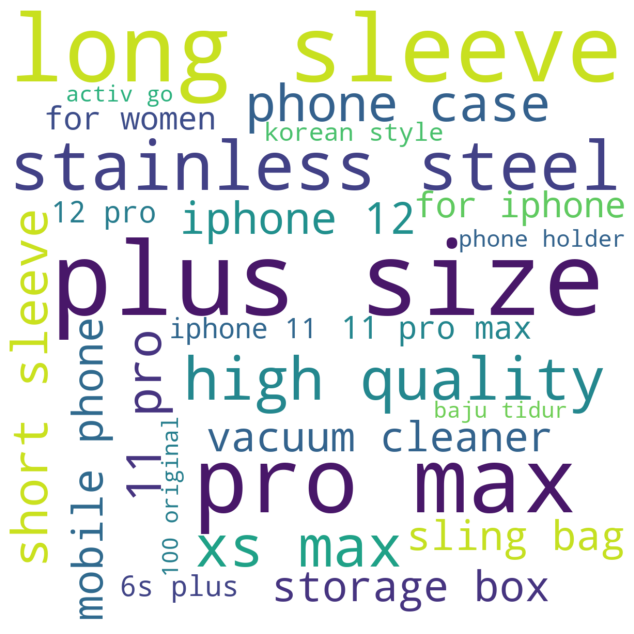

In [16]:
from wordcloud import WordCloud, STOPWORDS

# os.chdir("C:\\Users\\US\\Downloads\\Trending ATC\\malay_stopwords\\stopwords_dicts")
# malayStopWords = pd.read_excel('stop_words_ms.xlsx')
# malayStopWords = malayStopWords['stopwords'].tolist()

stopwords = set(STOPWORDS)
stopwords = list(stopwords) + malayStopWords

%matplotlib inline
# Generate N-gram wordcloud
wordcloud = WordCloud(width = 1200, height = 1200,
                background_color ='white',
                stopwords = stopwords, max_words=25,
                relative_scaling = 1,
                collocations = True,
                min_font_size = 10).generate_from_frequencies(df2_dict)
  
# plot the WordCloud image                       
plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 5)

plt.show()

Text(0.5, 1.0, 'Top N-gram keywords vs their count')

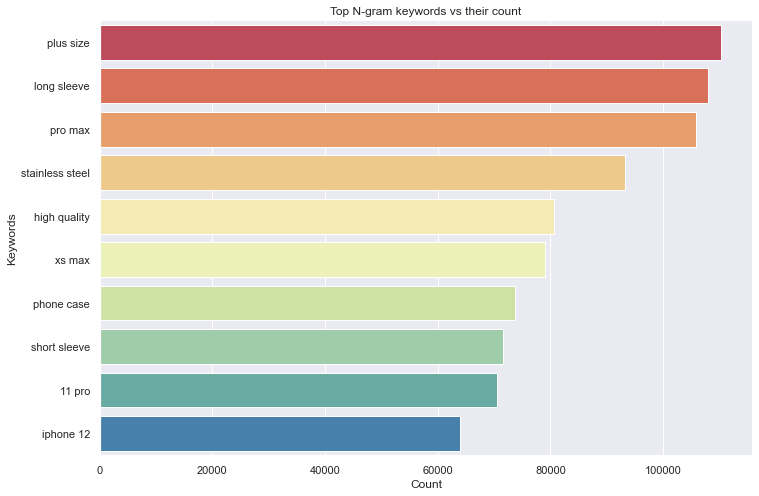

In [10]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8)})

ax = sns.barplot(x="Count", y="Keywords", data=df2.head(10), palette="Spectral")
ax.set_title('Top N-gram keywords vs their count')

# For Previous Period

In [ ]:
d2 = d2.reindex(d2.index.repeat(d2.atc_d1))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# specify n-grams
c_vec = CountVectorizer(ngram_range=(2, 3))

# input to fit_transform() should be an iterable with strings
ngrams = c_vec.fit_transform(d2['name_d1'].to_list())

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

# count_values = ngrams.toarray().sum(axis=0)

# token = []

# # output n-grams
# for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
#     ng = {'Keywords':ng_text, 'Count':ng_count}
#     token.append(ng)
    
# df4 = pd.DataFrame(token)

terms = c_vec.get_feature_names()
freqs = ngrams.sum(axis=0).A1
result = dict(zip(terms, freqs))

df4 = pd.DataFrame(result.items(), columns=['Keywords', 'Count']).sort_values(by=['Count'], ascending = False)

In [ ]:
# Filter by max total words group by count
df4['totalwords'] = df4['Keywords'].str.split().str.len()
df4['max_totalwords'] = df4.groupby('Count')['totalwords'].transform(max)
df4 = df4[df4['totalwords'] == df4['max_totalwords']]
df4['ranking'] = np.arange(len(df4)) + 1

df4_dict = dict(zip(df4['Keywords'].tolist(), df4['Count'].tolist()))

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# os.chdir("C:\\Users\\US\\Downloads\\Trending ATC\\malay_stopwords\\stopwords_dicts")
# malayStopWords = pd.read_excel('stop_words_ms.xlsx')
# malayStopWords = malayStopWords['stopwords'].tolist()

stopwords = set(STOPWORDS)
stopwords = list(stopwords) + malayStopWords

%matplotlib inline
# Generate N-gram wordcloud
wordcloud = WordCloud(width = 1200, height = 1200,
                background_color ='white',
                stopwords = stopwords, max_words=100,
                relative_scaling = 1,
                collocations = True,
                min_font_size = 10).generate_from_frequencies(df4_dict)
  
# plot the WordCloud image                       
plt.figure(figsize = (12, 10), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 5)

plt.show()

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8)})

ax = sns.barplot(x="Count", y="Keywords", data=df4.head(10), palette="Spectral")
ax.set_title('Top N-gram keywords vs their count')

# Current Period vs Previous Period

In [ ]:
# df_merge = df2.join(df4.set_index('Keywords'), how='left', rsuffix=' D-1')
df_merge = df2.set_index('Keywords').join(df4.set_index('Keywords'), how='left', rsuffix=' D-1')
df_merge['ranking changes'] = df_merge['ranking D-1'] - df_merge['ranking']

df_merge = df_merge[df_merge.columns.drop(list(df_merge.filter(regex='totalwords')))]
df_merge = df_merge[df_merge.ranking <= 100]

df_merge

In [ ]:
df_merge = df_merge.reset_index()
df_merge = df_merge[['ranking','Keywords', 'Count', 'ranking D-1', 'Count D-1']]

In [ ]:
df_merge.to_csv('output.csv', index=True)

# Paste dataframe to Google Sheet ATC Mock Up 

In [ ]:
# google-sheets@eng-diagram-253506.iam.gserviceaccount.com
# google-sheets@light-sunlight-254508.iam.gserviceaccount.com
# google-sheets-3@striking-optics-254608.iam.gserviceaccount.com
# jupyter-sheets-4@i-backbone-254608.iam.gserviceaccount.com
# jupyter-sheets-5@possible-byte-254703.iam.gserviceaccount.com
# jupyter-sheets-6@calm-producer-254703.iam.gserviceaccount.com

CLIENT_COUNTER=0
LIST_OF_CLIENTS = refresh_client_emails()
logger.info('We have '+str(len(LIST_OF_CLIENTS))+' clients')

In [ ]:
key = '1ORJyq1PgR5donBBXebKZZWpEF_dpn6h9e0F9p0zGGQ8'
try_set_with_dataframe(key, 'Mock Up - Daily', df_merge, row=14, col=1, header=False)

In [ ]:
# df_merge